## Machine Learning Project 2

In [1]:
# scikit-learn pereptron and adaline implementations
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional

In [2]:
data = pd.read_csv('/Users/jaxen1/Shared/C/Machine Learning/project2/project_adult.csv')
validation = pd.read_csv('/Users/jaxen1/Shared/C/Machine Learning/project2/project_validation_inputs.csv')

## Data Preprocessing

In [3]:
# Function to preprocess data
def preprocess_data(df):
    # Take out educational since is ordinal, ordinal var is already in dataset
    df = df.drop(columns = ['Unnamed: 0', 'education'])
    # Handle missing values
    df = df.dropna()
    # Replace all values unknown with most common ('Private')
    df['workclass'] = df['workclass'].apply(lambda x: df['workclass'].value_counts().index[0] if x == '?' else x)

    # TRY EXCEPT SO VALIDATION SET CAN PASS
    # Binarize the target variable
    try:
        df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
    except:
        pass

    # keep track of rows indexes to connect X and y
    df = df.reset_index()

    # Deal with Categorical Values

    # initialize encoder
    encoder = OneHotEncoder(sparse_output=False)
    # pull categorical cols
    categorical_cols = df.select_dtypes(include='object').columns
    # create encoded array w one hot columns
    encoded_array = encoder.fit_transform(df[categorical_cols])
    # Get new column names
    encoded_cols = encoder.get_feature_names_out(categorical_cols)
    # Creae new df of encoded columns
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)
    # Drop the original cat cols, add the one hot encoded one
    df = df.drop(categorical_cols, axis=1)
    df = pd.concat([df, encoded_df], axis=1)
    df = df.drop('index', axis = 1)

    # Ensure all columns are numeric after one-hot encoding
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # TRY EXCEPTS SO THE VALIDATION SET CAN PASS WITH NO Y VARIABLE
    # Separate features and target
    try:
        X = df.drop(columns=['income'], axis=1)
    except:
        X = df
    try:
        y = df['income']
    except:
        y = None

    # Standardize numerical features
    numeric_cols = ['age','fnlwgt','capital-gain','capital-loss', 'hours-per-week']
    scaler = StandardScaler()
    # Ensure numeric columns exist before scaling
    numeric_cols_exist = [col for col in numeric_cols if col in X.columns]
    if numeric_cols_exist:
        X[numeric_cols_exist] = scaler.fit_transform(X[numeric_cols_exist])


    return X, y

In [4]:
# Run function on both datasets
X, y = preprocess_data(data)
X_validation, _ = preprocess_data(validation)
# Ensure validation set has same columns as training set and in right order
missing_cols = [
    'native-country_Holand-Netherlands',
    'native-country_Outlying-US(Guam-USVI-etc)',
    'workclass_Never-worked'
]
for col in missing_cols:
    X_validation[col] = 0
X_validation = X_validation.reindex(columns=X.columns, fill_value=0)
# Split the data 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


## MLP

This will need to be edited

In [5]:
class SimpleMLP:

    def __init__(self, num_features, num_hidden, num_classes, activation, random_seed=17):
        super().__init__()
        # Define number of classes and activation function type
        self.num_classes = num_classes
        self.activation_name = activation
        
        # Create random weights and biases
        rng = np.random.RandomState(random_seed)

        # Hidden Layer
        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        # Hidden Layer Bias
        self.bias_h = np.zeros(num_hidden)

        # Output Layer
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        # Output Layer Bias`
        self.bias_out = np.zeros(num_classes)
    
    """
    USE DIFFERENT ACTIVATION FUNCTIONS

    COMPARE:
    IDENTITY
    SIGMOID
    SOFTMAX
    RELU
    TANH
    """
        
    def activation(self, X, activation=None):
        if activation is None:
            activation = self.activation_name
        if activation == "sigmoid":
            return 1 / (1 + np.exp(-X))
        elif activation == "relu":
            return np.maximum(0, X)
        elif activation == "tanh":
            return np.tanh(X)
        elif activation == "identity":
            return X
        else:
            return X
    
        
    def activation_derivative(self, X, activation=None):
        if activation is None:
            activation = self.activation_name
        if activation == "sigmoid":
            sig = self.activation(X, activation)
            return sig * (1 - sig)
        elif activation == "relu":
            return (X > 0).astype(float)
        elif activation == "tanh":
            return 1 - np.tanh(X)**2
        elif activation == "identity":
            return np.ones_like(X)
        else:
            return np.ones_like(X)
    
    # Create function for sigmoid
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    # Forward pass function
    def forward(self, x):
        # Hidden layer
        self.z_h = np.dot(x, self.weight_h.T) + self.bias_h
        self.a_h = self.activation(self.z_h, self.activation_name)
        # Output layer
        self.z_out = np.dot(self.a_h, self.weight_out.T) + self.bias_out
        self.a_out = self.sigmoid(self.z_out) # Since is binary classification, use sigmoid for output layer
        return self.a_h, self.a_out

    def backward(self, x, y_onehot):  

        samples = x.shape[0]
        #################################
        
        # Output layer gradients
        delta_out = (self.a_out - y_onehot) / samples
        d_weight_out = np.dot(delta_out.T, self.a_h)
        d_bias_out = np.sum(delta_out, axis=0)

        # Hidden layer gradients
        delta_h = np.dot(delta_out, self.weight_out) * self.activation_derivative(self.z_h, self.activation_name)
        d_weight_h = np.dot(delta_h.T, x)
        d_bias_h = np.sum(delta_h, axis=0)

        return (d_weight_out, d_bias_out, d_weight_h, d_bias_h)

In [6]:
def mse_loss(onehot_targets, probas):
    mse = np.mean((onehot_targets - probas)**2)
    return mse

def cross_entropy_loss(onehot_targets, probas):
    # Clip probabilities to avoid log(0)
    probas = np.clip(probas, 1e-15, 1 - 1e-15)
    ce = -np.mean(np.sum(onehot_targets * np.log(probas) + (1 - onehot_targets) * np.log(1 - probas), axis=1))
    return ce

In [7]:
encoder = OneHotEncoder(sparse_output=False)
y_hot_train = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_hot_test = encoder.transform(y_test.values.reshape(-1, 1))

In [8]:
def train(model, X_train, X_test, y_onehot_train, y_onehot_test, num_epochs, num_classes, learning_rate=0.01):

    """
    Training Simple MLP modle using entire data set (no train/test split)
    """
  
    epoch_loss_train = []
    epoch_loss_test = []
    
    for e in range(num_epochs):
        print(f"****Epoch: {e}****")

        #### Compute outputs ####
        a_h, a_out = model.forward(X_train)

        #### Compute gradients ####
        d_weight_out, d_bias_out, d_weight_h, d_bias_h = model.backward(X_train, y_onehot_train)

        #### Update weights ####
        model.weight_out -= learning_rate * d_weight_out
        model.bias_out -= learning_rate * d_bias_out
        model.weight_h -= learning_rate * d_weight_h
        model.bias_h -= learning_rate * d_bias_h

        ### Look at test dataset ###
        _, a_out_test = model.forward(X_test)
    
        #### Epoch Logging ####        
        trainLoss = cross_entropy_loss(y_onehot_train, a_out)
        testLoss = cross_entropy_loss(y_onehot_test, a_out_test)
        epoch_loss_train.append(trainLoss)
        epoch_loss_test.append(testLoss)
        print(f'MSE Train: {trainLoss:.2f}')
        print(f'MSE Test: {testLoss:.2f}')

    return epoch_loss_train, epoch_loss_test



In [9]:
model = SimpleMLP(num_features=len(X_train.columns), num_hidden=2, num_classes=2, activation = 'tanh')

In [10]:
epoch_loss_train, epoch_loss_test = train(model, X_train, X_test, y_hot_train, y_hot_test, num_epochs=1000, learning_rate=0.1, num_classes = 2)

****Epoch: 0****
MSE Train: 1.43
MSE Test: 1.40
****Epoch: 1****
MSE Train: 1.40
MSE Test: 1.37
****Epoch: 2****
MSE Train: 1.37
MSE Test: 1.35
****Epoch: 3****
MSE Train: 1.35
MSE Test: 1.33
****Epoch: 4****


MSE Train: 1.33
MSE Test: 1.31
****Epoch: 5****
MSE Train: 1.31
MSE Test: 1.29
****Epoch: 6****
MSE Train: 1.29
MSE Test: 1.27
****Epoch: 7****
MSE Train: 1.27
MSE Test: 1.26
****Epoch: 8****
MSE Train: 1.25
MSE Test: 1.24
****Epoch: 9****
MSE Train: 1.24
MSE Test: 1.23
****Epoch: 10****
MSE Train: 1.22
MSE Test: 1.21
****Epoch: 11****
MSE Train: 1.21
MSE Test: 1.20
****Epoch: 12****
MSE Train: 1.20
MSE Test: 1.19
****Epoch: 13****
MSE Train: 1.19
MSE Test: 1.18
****Epoch: 14****
MSE Train: 1.18
MSE Test: 1.17
****Epoch: 15****
MSE Train: 1.17
MSE Test: 1.16
****Epoch: 16****
MSE Train: 1.16
MSE Test: 1.16
****Epoch: 17****
MSE Train: 1.15
MSE Test: 1.15
****Epoch: 18****
MSE Train: 1.15
MSE Test: 1.15
****Epoch: 19****
MSE Train: 1.14
MSE Test: 1.14
****Epoch: 20****
MSE Train: 1.14
MSE Test: 1.14
****Epoch: 21****
MSE Train: 1.13
MSE Test: 1.13
****Epoch: 22****
MSE Train: 1.13
MSE Test: 1.13
****Epoch: 23****
MSE Train: 1.13
MSE Test: 1.13
****Epoch: 24****
MSE Train: 1.12
MSE Test:

In [12]:
epoch_loss_test

[1.3998020397713637,
 1.3720434702804118,
 1.3484950635624195,
 1.327508046514464,
 1.3080966745532816,
 1.289755682501021,
 1.2723059810506159,
 1.2557745146042913,
 1.2402815481638736,
 1.2259495519452919,
 1.2128532003495376,
 1.2010074069632861,
 1.1903765256304117,
 1.1808900808689862,
 1.1724574793325662,
 1.1649792093354043,
 1.1583544143404727,
 1.152485535353168,
 1.147280832470008,
 1.142655466168661,
 1.1385316366792384,
 1.1348381148191398,
 1.1315093673700005,
 1.1284843822917472,
 1.1257052275276578,
 1.1231153302046186,
 1.120657453558233,
 1.1182714236166047,
 1.1158919357964958,
 1.1134475018193215,
 1.1108631437875542,
 1.1080717613219169,
 1.1050395856598172,
 1.101801044438118,
 1.0984702394718917,
 1.0951849914945966,
 1.092016228235968,
 1.0889499169436463,
 1.0859436628699806,
 1.082967022561354,
 1.0800048138691862,
 1.0770502201417194,
 1.0740999765393997,
 1.0711521418103092,
 1.068205264517707,
 1.065258133334169,
 1.0623097158078283,
 1.0593591430363873,
 1.

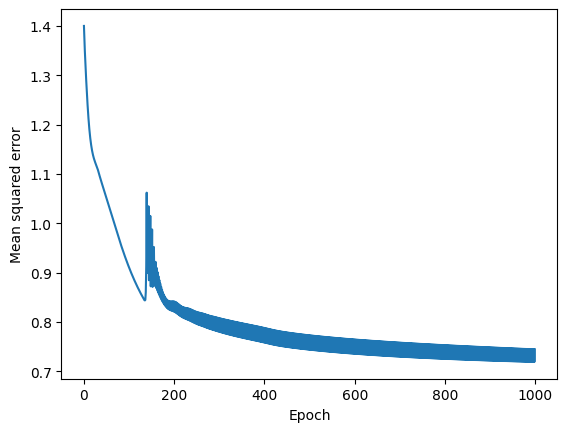

In [14]:
plt.plot(range(len(epoch_loss_test)), epoch_loss_test)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

## Reflection and Conceptual Questions

### Why did you choose the specific architecture (e.g., number of layers, activation functions) for each model?

### How did you monitor and mitigate overfitting in your models?

### What ethical concerns might arise from deploying models trained on these datasets?

### Why are activation functions necessary in neural networks?